In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from pymongo import MongoClient
import datetime
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from talib import abstract

from functools import partial

In [2]:
#Download Data from yahoo
### TEST Scnarios - TCS- Bull ,ACC- modrate up (Sidewase),YESBank- Back to Zero ,ITC(stock dosnt even Move)
stock='ACC'
startdate='2007-01-01'
enddate='2022-01-01'
exchange=['.NS','.BO']
dfo = yf.download(stock+exchange[0],start=startdate)

[*********************100%***********************]  1 of 1 completed


## Note that if α=1, the SES model is equivalent to a random walk model (without growth). If α=0, the SES model is equivalent to the mean model, assuming that the first smoothed value is set equal to the mean.

In [3]:
#
def rwema(windows,df1,field):
    for window in windows:
        alpha=1/window
        weights=list(reversed([(1)**n for n in range(window)]))
        weights_T=list(reversed([(1-alpha)**n for n in range(window)]))
        ewma = partial(np.average, weights=weights)
        ewma_T = partial(np.average, weights=weights_T)
        df1[f'{window}RWEMA'] = df1[field].rolling(window).apply(ewma)
        df1[f'{window}RWEMA_T'] = df1[field].rolling(window).apply(ewma_T)
        df1[f'{window}rma_a_dis']=((df1[f'{window}RWEMA_T']/df1[f'{window}RWEMA'])-1)*100
        df1.dropna(inplace=True)
    return df1

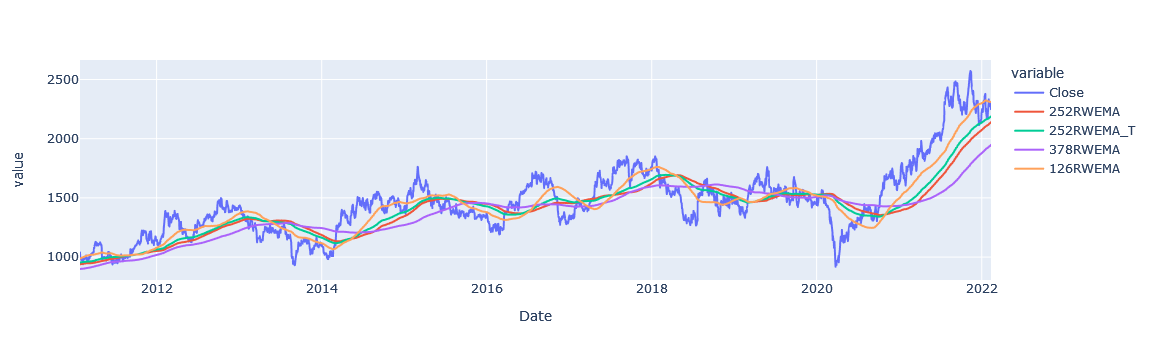

In [19]:
## Making Copy of Dataframe for further analysis and changes
df=dfo.copy()
# Adding feild called % Daily changes out of 100%
df['pct_change']=(df['Close'].pct_change())*100
df.dropna(inplace=True)

windows=[378,252,189,126,63]
df1=rwema(windows,df,'Close')
fig=px.line(df1[['Close','252RWEMA','252RWEMA_T','378RWEMA','126RWEMA']])
fig.show()

In [5]:
def mov(bins,df,field):
    temp=bins
    #temp=[-500,-400,-300,-200,-100,-50,-30,-20,-15,-10,-5,-2,-1,0,1,2,5,10,15,20,30,50,100,200,300,400,500]
    len(temp) #--13
    range(len(temp)) #--(0,13)
    temp.index(0) #-- Zero at 6th Index
    neg={}
    pos={}


    for i in range(0,temp.index(0)):
        # print(i+1+temp.index(0),temp.index(0)-1-i)
        # print(f" Searching from {temp[temp.index(0)]} to {temp[temp.index(0)-1-i]}")
        tempcountneg=df[field].loc[(df[field]>temp[temp.index(0)-1-i])&(df[field]<temp[temp.index(0)])].count()
        neg[f"{temp[temp.index(0)]} - {temp[temp.index(0)-1-i]}"]=tempcountneg
        # neglist.append(tempcountneg*-1)

        # print(f" Searching from {temp[temp.index(0)]} to {temp[i+1+temp.index(0)]}")
        tempcountpos=df[field].loc[(df[field]<temp[i+1+temp.index(0)])&(df[field]>temp[temp.index(0)])].count()
        pos[f"{temp[temp.index(0)]} - {temp[i+1+temp.index(0)]}"]=tempcountpos
        # poslist.append(tempcountpos)
    negdf=pd.DataFrame(neg,index=[0])
    posdf=pd.DataFrame(pos,index=[0]) 

    ## .iloc[::-1] to reverse the Dataframe
    # negdf=negdf.T.iloc[::-1]
    negdf=negdf.T
    posdf=posdf.T

    #######Setting the coulmns
    negdf.reset_index(inplace=True)
    negdf.columns=['Range','Total']
    negdf.set_index('Range',inplace=True)

    posdf.reset_index(inplace=True)
    posdf.columns=['Range','Total']
    posdf.set_index('Range',inplace=True)

    ######Calculating total change between days
    negdf['Diff']=abs(negdf['Total']-negdf['Total'].shift(1))
    negdf.replace(to_replace=np.nan,value=0,inplace=True)
    negdf['%Reach']=abs((negdf['Diff']/negdf['Total'][temp.index(0)-1])*100)
    # print(negdf['Total'][temp.index(0)-1])


    posdf['Diff']=abs(posdf['Total']-posdf['Total'].shift(1))
    posdf.replace(to_replace=np.nan,value=0,inplace=True)
    posdf['%Reach']=abs((posdf['Diff']/posdf['Total'][temp.index(0)-1])*100)
    # print(posdf['Total'][temp.index(0)-1])

    ######Reversing the datatable
    negdf=negdf.iloc[::-1]

    newdf=negdf.append(posdf)
    return newdf

    # df['RWEMA_252_movement'].loc[(df['RWEMA_252_movement']>-15)&(df['RWEMA_252_movement']<0)].count()

In [6]:
bins=[-10,-5,-4,-3,-2,-1,-0.5,0,0.5,1,2,3,4,5,10]
# gp=df1.groupby('rma_a_dis')['rma_a_dis'].count()
# gp=gp.Close.count()
newdf252=mov(bins,df1,'252rma_a_dis')
newdf189=mov(bins,df1,'189rma_a_dis')
newdf126=mov(bins,df1,'126rma_a_dis')
newdf63=mov(bins,df1,'63rma_a_dis')

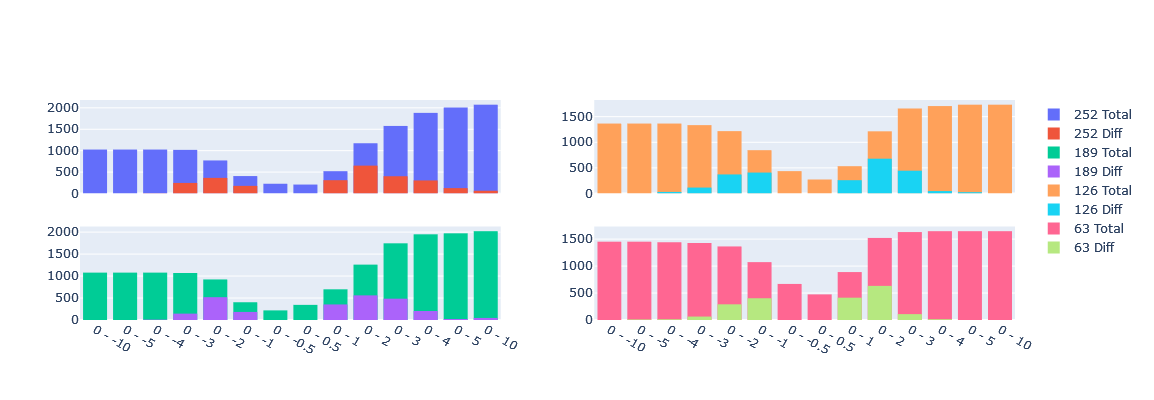

In [7]:
fig = make_subplots(rows=2, cols=2,shared_xaxes=True)
trace0 = go.Bar(x=newdf252.index,y=newdf252['Total'],name='252 Total')
trace1 = go.Bar(x=newdf252.index,y=newdf252['Diff'],name='252 Diff')
trace2 = go.Bar(x=newdf189.index,y=newdf189['Total'],name='189 Total')
trace3 = go.Bar(x=newdf189.index,y=newdf189['Diff'],name='189 Diff')
trace4 = go.Bar(x=newdf126.index,y=newdf126['Total'],name='126 Total')
trace5 = go.Bar(x=newdf126.index,y=newdf126['Diff'],name='126 Diff')
trace6 = go.Bar(x=newdf63.index,y=newdf63['Total'],name='63 Total')
trace7 = go.Bar(x=newdf63.index,y=newdf63['Diff'],name='63 Diff')


fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 2, 1)
fig.append_trace(trace3, 2, 1)
fig.append_trace(trace4, 1, 2)
fig.append_trace(trace5, 1, 2)
fig.append_trace(trace6, 2, 2)
fig.append_trace(trace7, 2, 2)

fig.update_traces(dict(marker_line_width=0))

fig.update_layout(autosize=False,width=1200,height=400,paper_bgcolor="white",barmode='overlay')


fig.show()


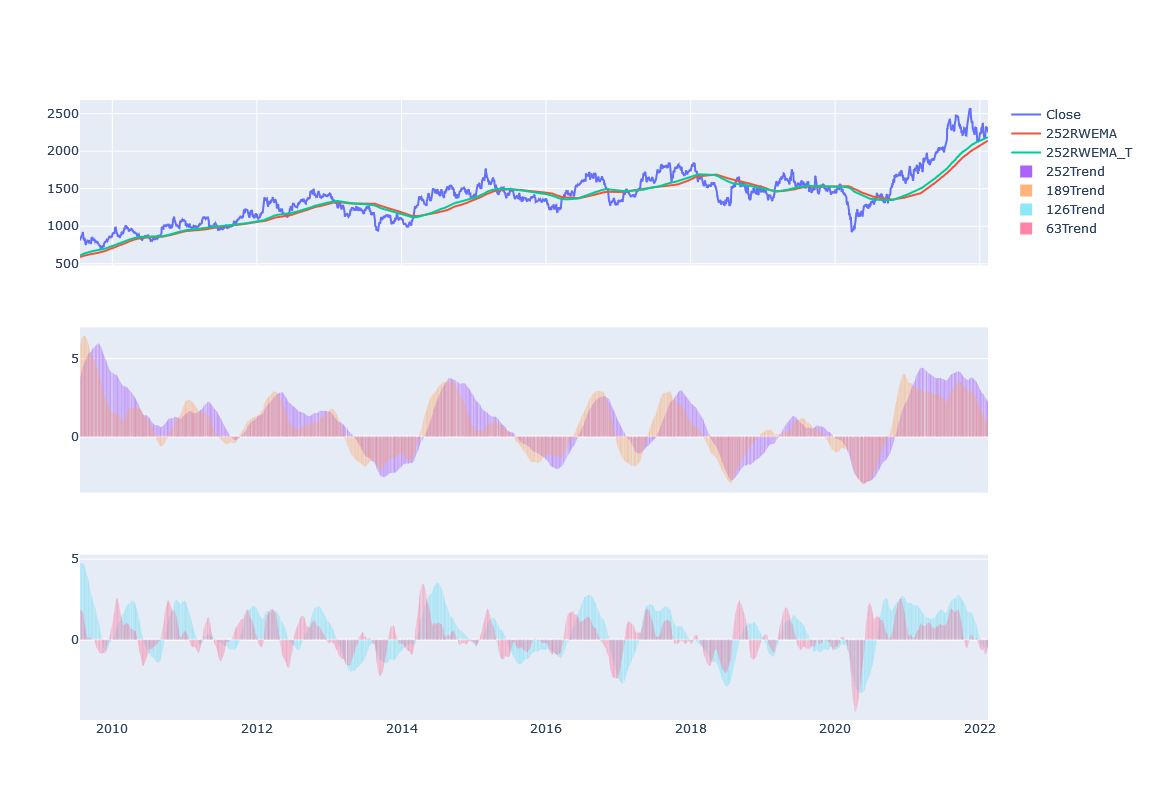

In [8]:
fig = make_subplots(rows=3, cols=1,shared_xaxes=True)
trace0 = go.Scatter(x=df1.index,y=df1['Close'],mode='lines',name='Close')
trace1 = go.Scatter(x=df1.index,y=df1['252RWEMA'],mode='lines',name='252RWEMA')
trace2 = go.Scatter(x=df1.index,y=df1['252RWEMA_T'],mode='lines',name='252RWEMA_T')
trace3 = go.Bar(x=df1.index,y=df1['252rma_a_dis'],name='252Trend',opacity=1)
trace4 = go.Bar(x=df1.index,y=df1['189rma_a_dis'],name='189Trend',opacity=0.8)
trace5 = go.Bar(x=df1.index,y=df1['126rma_a_dis'],name='126Trend',opacity=0.5)
trace6 = go.Bar(x=df1.index,y=df1['63rma_a_dis'],name='63Trend',opacity=0.8)


fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 1)
fig.append_trace(trace3, 2, 1)
fig.append_trace(trace4, 2, 1)
fig.append_trace(trace5, 3, 1)
fig.append_trace(trace6, 3, 1)

fig.update_traces(dict(marker_line_width=0))


fig.update_layout(autosize=False,width=1200,height=800,paper_bgcolor="white",barmode='overlay',activeshape_opacity=0.5)

fig.show()


In [9]:
def backtester(start,end,init_df,trade_type,ma):
    bt=pd.DataFrame({'StartDate':start,'EndDate':end})
    bt.replace(to_replace=np.nan,value=0,inplace=True)
    
    dataframes=[]
    pc_=[]
    
    if trade_type=='long':
        
        for index in bt.index:
            init_df_tmp=(init_df.loc[(init_df.index>=bt['StartDate'][index]) & (init_df.index<=bt['EndDate'][index])]).copy()
            ## Setting up Default Variables
            pos=0
            num=0
            percentchange=[]
            day_count=0
            init_df_tmp['pos_days']=0
            init_df_tmp['s_daily_change']=0.0
            init_df_tmp['u_daily_Return']=0.0
            s_st=[]
            trigger_p=[]
            lastpc=[0,]
            
            s_start=0
            #### price at time of start date of this stratgy
            u_st=init_df_tmp['Close'][0]
            
            for i in init_df_tmp.index:
                CP=init_df_tmp['Close'][i]
                # Underline Daily return from the start date of Stratgy
                if s_start!=0:
                    init_df_tmp.at[i,'u_daily_Return']=init_df_tmp['pct_change'][i]
                
                if i != init_df_tmp.index[9]:##############3 Passing first 10 Days

                    #############Conditions######################
                    #############Long Position###################
                    long_condition=(init_df_tmp['189rma_a_dis'][i]> init_df_tmp['189rma_a_dis'].shift(5)[i]) & (init_df_tmp['189rma_a_dis'].shift(5)[i]< init_df_tmp['189rma_a_dis'].shift(10)[i])|(init_df_tmp['252rma_a_dis'][i]> init_df_tmp['252rma_a_dis'].shift(5)[i]) & (init_df_tmp['252rma_a_dis'].shift(5)[i]< init_df_tmp['252rma_a_dis'].shift(10)[i])
                    
                    #############Long SL/Exit#########################
                    long_exit=(init_df_tmp['200rma_a_dis'][i]< init_df_tmp['200rma_a_dis'].shift(5)[i]) & (init_df_tmp['200rma_a_dis'].shift(5)[i]> init_df_tmp['200rma_a_dis'].shift(10)[i])&(init_df_tmp['63rma_a_dis'][i]< init_df_tmp['63rma_a_dis'].shift(5)[i])
                    
                    #############Short SL/Exit#########################
                
                  
                    
                    ## Enter into Long
                    if not s_st:
                        if long_condition:                
                            if(pos==0):
                                print(f"Long Buy Triggred")
                                s_start=1
                                bp=CP
                                pos=1
                                print(f"Buying now at {str(bp)} on {i}")
                                init_df_tmp.at[i,'pos_days']=day_count
                                if not s_st: # to check if any long or short position already triggred or not. if s_st have value ,means already atleast one trade happned.
                                    s_st.append(bp)
                    if s_st:
                        if(pos==1):
                            day_count+=1
                            init_df_tmp.at[i,'pos_days']=day_count
                            init_df_tmp.at[i,'s_daily_change']=init_df_tmp['pct_change'][i]

                    ## Long SL/Exit       
                        if long_exit:                
                            if(pos==1):
                                print("Long Covering Triggred")
                                day_count=0
                                pos=0
                                sp=CP
                                print(f"Existing now at {str(sp)} on {i}")
                                pc=(sp/bp-1)*100
                                percentchange.append(pc)
                                init_df_tmp.at[i,'pos_days']=day_count
                                s_st.clear()


                        if(num==init_df_tmp["Close"].count()-1 and pos==1):
                            pos=0
                            sp=CP
                            day_count=0
                            print(f"Existing now at {str(sp)} on {i}")
                            pc=(sp/bp-1)*100
                            percentchange.append(pc)
                            init_df_tmp.at[i,'pos_days']=day_count
                            s_st.clear()


                num+=1    
                pc_.append(percentchange)

                #################################for Performance Matrix############
                # Stratgy Cummulative returns and Underline Cummulative returns
                init_df_tmp['scr']=((1+(init_df_tmp['s_daily_change']/100)).cumprod()-1)*100
                init_df_tmp['ucr']=((1+(init_df_tmp['u_daily_Return']/100)).cumprod()-1)*100        
                
                gains=0
                ng=0
                losses=0
                nl=0
                for i in percentchange:
                    if(i>0):
                        gains+=i
                        ng+=1
                    else:
                        losses+=i
                        nl+=1

                if(ng>0):
                    avgGain=gains/ng
                    maxR=max(percentchange)
                else:
                    avgGain=0
                    maxR=0

                if(nl>0):
                    avgLoss=losses/nl
                    maxL=min(percentchange)
                    ratio=-avgGain/avgLoss
                else:
                    avgLoss=0
                    maxL=0
                    ratio=999

                if(ng>0 or nl>0):
                    battingAvg=(ng/(ng+nl))*100
                else:
                    battingAvg=0
                ### Adding matrix to BackTEST Dataframe#####
                bt.at[index,'MA']=ma
                bt.at[index,'#Trades']=ng+nl
                bt.at[index,'Win avg']=round(battingAvg,2)
                bt.at[index,'#Wins']=ng
                bt.at[index,'#loss']=nl
                bt.at[index,'Gain/loss ratio']=round(ratio,2)
                bt.at[index,'Average Gain %']=round(avgGain,2)
                bt.at[index,'Average Loss %']=round(avgLoss,2)
                bt.at[index,'Max Return %']=round(maxR,2)
                bt.at[index,'Max Loss %']=round(maxL,2)
                bt.at[index,'Stratergy-Cum Total return %']=round(init_df_tmp['scr'][-1],2)
                bt.at[index,'Underline-Cum Total return %']=round(init_df_tmp['ucr'][-1],2)

                ## Adding Result Dataframe into List of Dataframes
                dataframes.append(init_df_tmp)
                
    return bt,dataframes

### 71% compare to 45% for ACC from 2010,2020
#############Long Position###################
#### long_condition=(init_df_tmp['189rma_a_dis'][i]> init_df_tmp['189rma_a_dis'].shift(9)[i]) & (init_df_tmp['189rma_a_dis'].shift(1)[i]< -0.5)
#############Long Exit##############
#### long_exit=(init_df_tmp['126rma_a_dis'][i]< init_df_tmp['189rma_a_dis'].shift(9)[i])


In [10]:
## Making Copy of Dataframe for further analysis and changes
df=dfo.copy()
# Adding feild called % Daily changes out of 100%
df['pct_change']=(df['Close'].pct_change())*100
df.dropna(inplace=True)

windows=[300,252,200,189,150,126,100,63]
df1=rwema(windows,df,'Close')

start=['2010-01-01']
end=['2020-01-01']
result,result_dataframes=backtester(start=start,end=end,init_df=df1,trade_type='long',ma=200)

Long Buy Triggred
Buying now at 1335.0 on 2012-08-07 00:00:00
Long Covering Triggred
Existing now at 1343.5 on 2012-09-13 00:00:00
Long Buy Triggred
Buying now at 1447.75 on 2012-09-27 00:00:00
Long Covering Triggred
Existing now at 1401.300048828125 on 2012-10-25 00:00:00
Long Buy Triggred
Buying now at 1473.4000244140625 on 2012-11-06 00:00:00
Long Covering Triggred
Existing now at 1382.6500244140625 on 2012-11-19 00:00:00
Long Buy Triggred
Buying now at 1414.800048828125 on 2012-12-07 00:00:00
Long Covering Triggred
Existing now at 1355.0999755859375 on 2013-01-23 00:00:00
Long Buy Triggred
Buying now at 1236.0 on 2013-07-04 00:00:00
Long Covering Triggred
Existing now at 1075.0 on 2013-08-20 00:00:00
Long Buy Triggred
Buying now at 1123.25 on 2013-09-20 00:00:00
Long Covering Triggred
Existing now at 1037.1500244140625 on 2014-01-13 00:00:00
Long Buy Triggred
Buying now at 1046.449951171875 on 2014-02-07 00:00:00
Long Covering Triggred
Existing now at 1025.800048828125 on 2014-02-1

In [11]:
result

StartDate     EndDate     MA  #Trades  Win avg  #Wins  #loss  \
0  2010-01-01  2020-01-01  200.0     21.0    23.81    5.0   16.0   

   Gain/loss ratio  Average Gain %  Average Loss %  Max Return %  Max Loss %  \
0             4.37           20.21           -4.62         45.48      -13.03   

   Stratergy-Cum Total return %  Underline-Cum Total return %  
0                         29.54                          7.87

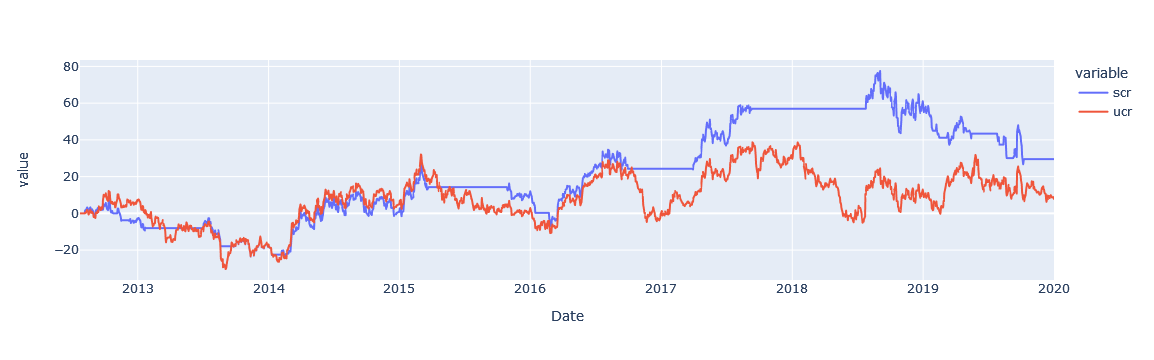

In [12]:
result_df=result_dataframes[0]
fig=px.line(result_df[['scr','ucr']],)
fig.show()

In [13]:
result_df

Open         High          Low        Close    Adj Close  \
Date                                                                          
2012-07-24  1254.650024  1277.500000  1252.300049  1269.650024  1081.226929   
2012-07-25  1262.150024  1292.000000  1262.150024  1276.199951  1086.805054   
2012-07-26  1283.000000  1289.150024  1252.300049  1260.849976  1073.732910   
2012-07-27  1289.900024  1309.000000  1280.550049  1293.750000  1101.750488   
2012-07-30  1308.000000  1308.000000  1288.650024  1297.849976  1105.241943   
...                 ...          ...          ...          ...          ...   
2019-12-26  1464.400024  1470.000000  1448.099976  1451.699951  1402.383545   
2019-12-27  1456.000000  1470.000000  1448.650024  1451.300049  1401.997314   
2019-12-30  1455.599976  1474.949951  1450.400024  1453.050049  1403.687744   
2019-12-31  1454.500000  1460.000000  1441.550049  1445.650024  1396.539185   
2020-01-01  1452.500000  1457.000000  1438.199951  1440.099976  1391.177734   

            Volume  pct_change     300RWEMA   300RWEMA_T  300rma_a_dis  ...  \
Date                                                                    ...   
2012-07-24  241854    1.296474  1145.405500  1171.789686      2.303480  ...   
2012-07-25  587058    0.515884  1146.364833  1172.694557      2.296801  ...   
2012-07-26  664339   -1.202788  1147.280667  1173.519997      2.287089  ...   
2012-07-27  516839    2.609353  1148.268667  1174.494240      2.283923  ...   
2012-07-30  264596    0.316906  1149.260000  1175.480837      2.281541  ...   
...            ...         ...          ...          ...           ...  ...   
2019-12-26  324912   -0.609340  1517.440334  1521.817328      0.288446  ...   
2019-12-27  395778   -0.027547  1517.245668  1521.469278      0.278374  ...   
2019-12-30  433982    0.120582  1516.996168  1521.096394      0.270286  ...   
2019-12-31  581119   -0.509275  1516.886335  1520.781154      0.256764  ...   
2020-01-01  321092   -0.383914  1516.771168  1520.445369      0.242238  ...   

             100RWEMA_T  100rma_a_dis      63RWEMA    63RWEMA_T  63rma_a_dis  \
Date                                                                           
2012-07-24  1239.141832     -0.572877  1209.796819  1219.913301     0.836213   
2012-07-25  1239.247689     -0.527788  1210.707136  1221.329858     0.877398   
2012-07-26  1239.015675     -0.484425  1211.751579  1222.557357     0.891749   
2012-07-27  1239.528954     -0.438481  1212.649991  1224.203676     0.952763   
2012-07-30  1240.141898     -0.393369  1213.999198  1226.147993     1.000725   
...                 ...           ...          ...          ...          ...   
2019-12-26  1505.320513     -0.443016  1505.095238  1495.699982    -0.624230   
2019-12-27  1504.293011     -0.455406  1501.928571  1493.175480    -0.582790   
2019-12-30  1503.273364     -0.465017  1499.061905  1490.891224    -0.545053   
2019-12-31  1502.034602     -0.471418  1495.880952  1488.345159    -0.503770   
2020-01-01  1500.981075     -0.491643  1492.793651  1485.805229    -0.468144   

            pos_days  s_daily_change  u_daily_Return        scr       ucr  
Date                                                                       
2012-07-24         0             0.0        0.000000   0.000000  0.000000  
2012-07-25         0             0.0        0.000000   0.000000  0.000000  
2012-07-26         0             0.0        0.000000   0.000000  0.000000  
2012-07-27         0             0.0        0.000000   0.000000  0.000000  
2012-07-30         0             0.0        0.000000   0.000000  0.000000  
...              ...             ...             ...        ...       ...  
2019-12-26         0             0.0       -0.609340  29.542306  8.741569  
2019-12-27         0             0.0       -0.027547  29.542306  8.711614  
2019-12-30         0             0.0        0.120582  29.542306  8.842700  
2019-12-31         0             0.0       -0.509275  29.542306  8.288391  
2020-01-01

In [14]:

result_df.groupby('pos_days')['pos_days'].all()

pos_days
0      False
1       True
2       True
3       True
4       True
       ...  
254     True
255     True
256     True
257     True
258     True
Name: pos_days, Length: 259, dtype: bool

In [15]:
df1

Open         High          Low        Close    Adj Close  \
Date                                                                          
2012-07-24  1254.650024  1277.500000  1252.300049  1269.650024  1081.226929   
2012-07-25  1262.150024  1292.000000  1262.150024  1276.199951  1086.805054   
2012-07-26  1283.000000  1289.150024  1252.300049  1260.849976  1073.732910   
2012-07-27  1289.900024  1309.000000  1280.550049  1293.750000  1101.750488   
2012-07-30  1308.000000  1308.000000  1288.650024  1297.849976  1105.241943   
...                 ...          ...          ...          ...          ...   
2022-02-07  2282.699951  2292.750000  2239.250000  2282.199951  2282.199951   
2022-02-08  2286.000000  2310.000000  2262.199951  2304.750000  2304.750000   
2022-02-09  2317.300049  2338.800049  2290.199951  2310.300049  2310.300049   
2022-02-10  2280.000000  2324.800049  2265.000000  2303.550049  2303.550049   
2022-02-11  2290.000000  2297.000000  2240.000000  2249.350098  2249.350098   

            Volume  pct_change     300RWEMA   300RWEMA_T  300rma_a_dis  ...  \
Date                                                                    ...   
2012-07-24  241854    1.296474  1145.405500  1171.789686      2.303480  ...   
2012-07-25  587058    0.515884  1146.364833  1172.694557      2.296801  ...   
2012-07-26  664339   -1.202788  1147.280667  1173.519997      2.287089  ...   
2012-07-27  516839    2.609353  1148.268667  1174.494240      2.283923  ...   
2012-07-30  264596    0.316906  1149.260000  1175.480837      2.281541  ...   
...            ...         ...          ...          ...           ...  ...   
2022-02-07  201382    0.327506  2057.532003  2122.676944      3.166169  ...   
2022-02-08  608392    0.988084  2059.462670  2124.404493      3.153338  ...   
2022-02-09  367725    0.240809  2061.508337  2126.211535      3.138634  ...   
2022-02-10  876424   -0.292170  2063.637670  2128.038617      3.120749  ...   
2022-02-11  359096   -2.352888  2065.493837  2129.520385      3.099818  ...   

            150rma_a_dis     126RWEMA   126RWEMA_T  126rma_a_dis     100RWEMA  \
Date                                                                            
2012-07-24      0.093332  1254.949202  1247.031519     -0.630917  1246.281494   
2012-07-25      0.075075  1255.827773  1247.771110     -0.641542  1245.822993   
2012-07-26      0.060220  1256.495233  1248.260916     -0.655340  1245.046993   
2012-07-27      0.055567  1257.447217  1249.172491     -0.658058  1244.987993   
2012-07-30      0.051204  1258.289678  1250.046032     -0.655147  1245.039493   
...                  ...          ...          ...           ...          ...   
2022-02-07     -0.076670  2311.253972  2300.532812     -0.463868  2297.599502   
2022-02-08     -0.112379  2310.963495  2300.398294     -0.457177  2295.973003   
2022-02-09     -0.148011  2310.945241  2300.466322     -0.453447  2294.779004   
2022-02-10     -0.180236  2310.997623  2300.521089     -0.453334  2293.866003   
2022-02-11     -0.220188  2310.785718  2299.992422     -0.467083  2293.100005   

             100RWEMA_T  100rma_a_dis      63RWEMA    63RWEMA_T  63rma_a_dis  
Date                                                                          
2012-07-24  1239.141832     -0.572877  1209.796819  1219.913301     0.836213  
2012-07-25  1239.247689     -0.527788  1210.707136  1221.329858     0.877398  
2012-07-26  1239.015675     -0.484425  1211.751579  1222.557357     0.891749  
2012-07-27  1239.528954     -0.438481  1212.649991  1224.203676     0.952763  
2012-07-30  1240.141898     -0.393369  1213.999198  1226.147993     1.000725  
...                 ...           ...          ...          ...          ...  
2022-02-07  2288.296407     -0.404905  2291.803967  2276.473542    -0.668924  
2022-02-08  2287.521855     -0.368086  2288.096823  2274.792045    -0.581478  
2022-02-09  2287.060261     -0.336361  2284.226190  2273.131386    -0.485714  
2022-02-10  2286.698022     -0.312485  2

In [ ]:
.378.